This is a notebook explaining the [Ink Detection progress prize on Kaggle](https://www.kaggle.com/competitions/vesuvius-challenge), which is part of the larger [Vesuvius Challenge](https://scrollprize.org).

For more background on the process of ink detection, be sure to check out [Tutorial 4: Ink Detection](https://scrollprize.org/tutorial4) on the Vesuvius Challenge website.

In this notebook we'll see how to train a simple ML model to detect ink in a papyrus fragment from a 3d x-ray scan of the fragment.

<img src="https://user-images.githubusercontent.com/177461/224853397-3cf86dc2-45b4-4e7c-9ec2-28a733791a75.jpg" width="200"/>

First, initialize some variables, and let's look at a photo of the fragment. We won't use this for training, but it's useful to see.

It's an infrared photo, since the ink is better visible in infrared light.

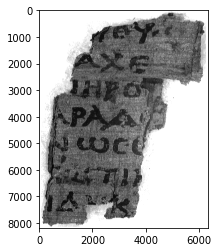

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

PREFIX = 'data/train/1/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.imshow(Image.open(PREFIX+"ir.png"), cmap="gray")

Let's load these binary images:
* **mask.png**: a mask of which pixels contain data, and which pixels we should ignore.
* **inklabels.png**: our label data: whether a pixel contains ink or no ink (which has been hand-labeled based on the infrared photo).

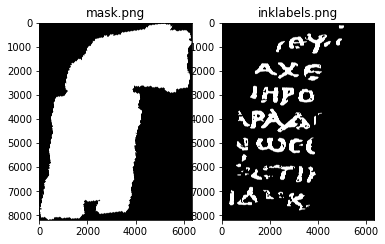

In [4]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

Next, we'll load the 3d x-ray of the fragment. This is represented as a .tif image stack. The image stack is an array of 16-bit grayscale images. Each image represents a "slice" in the z-direction, going from below the papyrus, to above the papyrus. We'll convert it to a 4D tensor of 32-bit floats. We'll also convert the pixel values to the range [0, 1].

To save memory, we'll only load the innermost slices (`Z_DIM` of them). Let's look at them when we're done.

100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


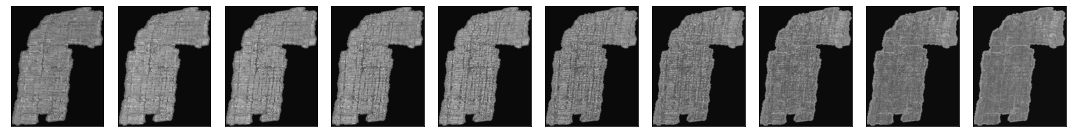

In [5]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

Can you see the ink in these slices of the 3d x-ray scan..? Neither can we.

Now we'll create a dataset of subvolumes. We use a small rectangle around the letter "P" for our evaluation, and we'll exclude those pixels from the training set. (It's actually a Greek letter "rho", which looks similar to our "P".)

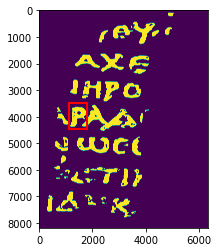

In [6]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

Now we'll define a PyTorch dataset and (super simple) model.

In [7]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

/usr/lib/python3/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Now we'll train the model. Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853655-3fad9edb-c798-452e-94d0-f74efe71c08e.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif"/></a>

This typically takes about 10 minutes.

In [8]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
# Adapted from https://www.kaggle.com/code/jamesdavey/100x-faster-pixel-coordinate-generator-1s-runtime
# Create a Boolean array of the same shape as the bitmask, initially all True
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
# Sets all indexes with inside_rect array to True
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
# Set the pixels within the inside_rect to False
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
# running_loss = 0.0
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
#     running_loss += loss.item()
#     if i % 3000 == 3000-1:
#         print("Loss:", running_loss / 3000)
#         running_loss = 0.0

Generating pixel lists...
Training...


100%|██████████| 30000/30000 [02:53<00:00, 172.69it/s]


Finally, we'll generate a prediction image. We'll use the model to predict the presence of ink for each pixel in our rectangle (the val set). Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853653-7cffd0a4-c6fa-49a2-93c1-e3c820863a51.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853379-09ae991e-02be-4ecc-a652-313165b3005c.gif"/></a>


This should take about a minute.

Remember that the model has never seen the label data within the rectangle before!

We'll plot it side-by-side with the label image. Are you able to recognize the letter "P" in it?

100%|██████████| 20833/20833 [00:37<00:00, 551.36it/s]


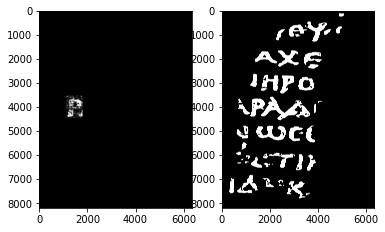

In [10]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[tuple(pixels_inside_rect[i*BATCH_SIZE+j])] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

Since our output has to be binary, we have to choose a threshold, say 40% confidence.

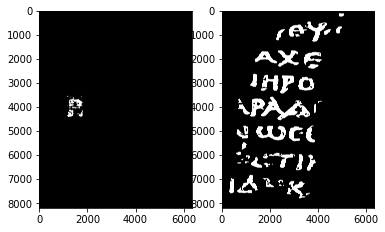

In [11]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

Finally, Kaggle expects a runlength-encoded submission.csv file, so let's output that.

In [12]:
# Adapted from https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook
# and https://www.kaggle.com/code/kotaiizuka/faster-rle/notebook
def rle(output):
    pixels = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

Hurray! We've detected ink! Now, can you do better? :-) For example, you could start with this [example submission](https://www.kaggle.com/code/danielhavir/vesuvius-challenge-example-submission).